# Modelling with GAN Augmented data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Deep Learning/Project/')

# Import necessary modules

In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
import cv2

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Generating Faces for each emotion

In [ ]:
# Number of images in train folder
import os

file_count = sum(len(files) for _, _, files in os.walk('output/train/'))
print(file_count)

199


In [ ]:
def create_dataset():
  total_images = 199
  img_arr = np.empty(shape=(total_images,48,48,1))
  img_label = np.empty(shape=(total_images),dtype = 'int')
  label_to_text = {}

  i = 0
  e = 0
  for dir_ in os.listdir('output/train/'):
      if dir_ in os.listdir('output/train/'):
          label_to_text[e] = dir_
          for f in os.listdir('output/train/' + "/" + dir_ + "/"):
              base_img = cv2.imread('output/train/' + "/"+ dir_ + "/" + f,0)
              img_arr[i] = np.reshape(base_img, (48,48,1))
              img_label[i] = e
              i += 1
          print(f"loaded all {dir_} images to numpy arrays")
          e += 1
  return img_arr, img_label, label_to_text

def generate_latent_points(latent_dim, n_samples, n_classes=7):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]

def emotion_data_generator(emotion, num_images):

  #Load model
  image_generator = load_model('ckplus_cgan_generator_2000.h5')

  latent_points, labels = generate_latent_points(100, num_images)
  # specify labels
  labels = np.random.randint(emotion, emotion+1, num_images)
  # generate images
  X  = image_generator.predict([latent_points, labels])
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0

  #print(X.shape)
  
  return np.stack(X)


In [ ]:
def new_data_generation(total_images):

  _,_,emotion_dict = create_dataset()

  num_images_per_emotion = total_images//7

  genset = []
  labels = []

  for (code, emotion) in emotion_dict.items():
    
    print('Generating images for ', emotion, ' ...')
    X = emotion_data_generator(code, num_images_per_emotion)
    labels.extend([code for j in range(num_images_per_emotion)])
    genset.append(X)
    print('Finished')

  return np.stack(genset), labels

genset, labels = new_data_generation(350)
genset = genset.reshape((350,48,48,1))
genset.shape, len(labels)

loaded all surprise images to numpy arrays
loaded all sadness images to numpy arrays
loaded all disgust images to numpy arrays
loaded all happy images to numpy arrays
loaded all contempt images to numpy arrays
loaded all anger images to numpy arrays
loaded all fear images to numpy arrays
Generating images for  surprise  ...
Finished
Generating images for  sadness  ...
Finished
Generating images for  disgust  ...
Finished
Generating images for  happy  ...
Finished
Generating images for  contempt  ...
Finished
Generating images for  anger  ...
Finished
Generating images for  fear  ...
Finished


((350, 48, 48, 1), 350)

5


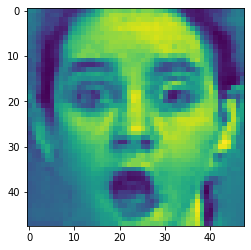

In [ ]:
# print random image
print(labels[250])
plt.imshow(genset[250,:,:,0]);

In [ ]:
# Load Original Train Data
og_images, og_labels, lt = create_dataset()
og_images.shape

loaded all surprise images to numpy arrays
loaded all sadness images to numpy arrays
loaded all disgust images to numpy arrays
loaded all happy images to numpy arrays
loaded all contempt images to numpy arrays
loaded all anger images to numpy arrays
loaded all fear images to numpy arrays


(199, 48, 48, 1)

In [ ]:
# New trainset = OG + GAN generated
full_trainset = np.vstack((og_images, genset))
full_train_labels = labels.copy()
full_train_labels.extend(og_labels)

full_trainset.shape, len(full_train_labels)

((549, 48, 48, 1), 549)

Creating test data

In [ ]:
# num of images in test set
file_count = sum(len(files) for _, _, files in os.walk('output/test/'))
print(file_count)

51


In [ ]:
total_images = 51
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images),dtype = 'int')
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir('output/test/'):
  if dir_ in os.listdir('output/test/'):
    label_to_text[e] = dir_
    for f in os.listdir('output/test/' + "/" + dir_ + "/"):
      base_img = cv2.imread('output/test/' + "/"+ dir_ + "/" + f,0)
      img_arr[i] = np.reshape(base_img, (48,48,1))
      img_label[i] = e
      i += 1
    print(f"loaded all {dir_} images to numpy arrays")
    e += 1
full_testset = img_arr
full_test_labels = img_label
full_testset.shape, len(full_test_labels)

loaded all surprise images to numpy arrays
loaded all sadness images to numpy arrays
loaded all disgust images to numpy arrays
loaded all happy images to numpy arrays
loaded all contempt images to numpy arrays
loaded all anger images to numpy arrays
loaded all fear images to numpy arrays


((51, 48, 48, 1), 51)

# Data Preparation

In [ ]:
# Conversion to numpy array
full_train_labels = np.array(full_train_labels)

In [ ]:
# Encoding the labels
import tensorflow as tf
full_train_labels1 = tf.keras.utils.to_categorical(full_train_labels)
full_test_labels1 = tf.keras.utils.to_categorical(full_test_labels)

In [ ]:
# convert each train and test image from 1 channel to 3 channel
full_trainset_3channel = []
for img in full_trainset:
  img2 = cv2.merge((img,img,img))
  full_trainset_3channel.append(img2)
full_trainset_3channel = np.stack(full_trainset_3channel)

full_testset_3channel = []
for img in full_testset:
  img2 = cv2.merge((img,img,img))
  full_testset_3channel.append(img2)
full_testset_3channel = np.stack(full_testset_3channel)
full_trainset_3channel.shape, full_testset_3channel.shape

((549, 48, 48, 3), (51, 48, 48, 3))

# Emotion detection using Augmented data and MobileNet Architecture

In [ ]:
# Resizing to (224,224,3) shape

dim = (224,224)
resized_train = []
for img in full_trainset_3channel:
  resized = np.empty((224,224,3))

  # Resize to fit (224,224,3)
  for channel in range(3):
    resized[:,:,channel] = cv2.resize(img[:,:,channel], dim, interpolation = cv2.INTER_AREA)
  #print('Resized to: ',resized.shape)
  resized_train.append(resized)
resized_train = np.stack(resized_train)

resized_test = []
for img in full_testset_3channel:
  resized = np.empty((224,224,3))

  # Resize to fit (224,224,3)
  for channel in range(3):
    resized[:,:,channel] = cv2.resize(img[:,:,channel], dim, interpolation = cv2.INTER_AREA)
  #print('Resized to: ',resized.shape)
  resized_test.append(resized)
resized_test = np.stack(resized_test)

resized_train.shape, resized_test.shape

((549, 224, 224, 3), (51, 224, 224, 3))

In [ ]:
mobile_net = MobileNet(
    input_shape = (224,224,3),
    include_top = False,
    weights = "imagenet",
    classes = 7
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(7, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
mod2 = model.fit(resized_train, full_train_labels1,batch_size = 4, epochs = 50 , validation_data= (resized_test, full_test_labels1))

Epoch 1/50
138/138 [==============================] - 8s 41ms/step - loss: 0.7909 - accuracy: 0.7923 - val_loss: 7.3063 - val_accuracy: 0.2353
Epoch 2/50
138/138 [==============================] - 5s 35ms/step - loss: 0.9058 - accuracy: 0.7778 - val_loss: 5.5281 - val_accuracy: 0.2353
Epoch 3/50
138/138 [==============================] - 5s 35ms/step - loss: 0.6836 - accuracy: 0.8397 - val_loss: 5.8303 - val_accuracy: 0.2549
Epoch 4/50
138/138 [==============================] - 5s 35ms/step - loss: 0.5176 - accuracy: 0.8616 - val_loss: 6.8009 - val_accuracy: 0.2353
Epoch 5/50
138/138 [==============================] - 5s 35ms/step - loss: 0.3777 - accuracy: 0.9126 - val_loss: 9.0632 - val_accuracy: 0.1765
Epoch 6/50
138/138 [==============================] - 5s 36ms/step - loss: 0.6373 - accuracy: 0.8689 - val_loss: 8.6242 - val_accuracy: 0.2549
Epoch 7/50
138/138 [==============================] - 5s 36ms/step - loss: 0.1507 - accuracy: 0.9508 - val_loss: 8.5062 - val_accuracy: 0.2353

In [ ]:
np.save('train_images_with_gan.npy',resized_train) 
np.save('full_train_labels_with_gan.npy',full_train_labels1)
np.save('test_images_with_gan.npy',resized_test)
np.save('full_test_labels_with_gan.npy',full_test_labels1)

#### The process of increasing dataset size using CGAN was successful. 
#### However, the model built using that data did not give very promising results. The earlier model with MobileNet architecture and tuning is the best model. 